In [3]:
import pandas as pd

# Dataset

In [ ]:
data = pd.read_csv('../data/WS22-WS23-augmented-train-gpt.tsv', sep='\t')

In [ ]:
data.columns

Index(['article_id', 'wrong_empathy', 'distress', 'emotion', 'gender',
       'education', 'race', 'age', 'income', 'personality_conscientiousness',
       'personality_openess', 'personality_extraversion',
       'personality_agreeableness', 'personality_stability',
       'iri_perspective_taking', 'iri_personal_distress', 'iri_fantasy',
       'iri_empathatic_concern', 'speaker_id', 'demographic_essay', 'article',
       'empathy'],
      dtype='object')

In [ ]:
data.rename(columns={'wrong_empathy': 'crowdsourced_empathy', 'empathy': 'gpt_empathy'}, inplace=True)
data.columns

Index(['article_id', 'crowdsourced_empathy', 'distress', 'emotion', 'gender',
       'education', 'race', 'age', 'income', 'personality_conscientiousness',
       'personality_openess', 'personality_extraversion',
       'personality_agreeableness', 'personality_stability',
       'iri_perspective_taking', 'iri_personal_distress', 'iri_fantasy',
       'iri_empathatic_concern', 'speaker_id', 'demographic_essay', 'article',
       'gpt_empathy'],
      dtype='object')

In [ ]:
data.to_csv('../data/v2_v3_train_augmented.tsv', sep='\t', index=False)

In [ ]:
dev_gpt = pd.read_csv('../../LLM-GEm/data/WS23-dev-gpt.tsv', sep='\t')
dev_gpt.columns, dev_gpt.shape

(Index(['conversation_id', 'article_id', 'essay', 'speaker_id', 'gender',
        'education', 'race', 'age', 'income', 'speaker_number', 'split',
        'essay_id', 'demographic', 'demographic_essay', 'article', 'empathy'],
       dtype='object'),
 (208, 16))

In [ ]:
dev_gpt.rename(columns={'empathy': 'gpt_empathy'}, inplace=True)

In [ ]:
dev_original = pd.read_csv('../../LLM-GEm/data/WASSA23/goldstandard_dev.tsv', sep='\t', header=None)
dev_original.columns, dev_original.shape

(Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64'), (208, 12))

In [ ]:
dev_gpt['crowdsourced_empathy'] = dev_original[0].to_list()

In [ ]:
dev_gpt.head(2)

,conversation_id,article_id,essay,speaker_id,gender,education,race,age,income,speaker_number,split,essay_id,demographic,demographic_essay,article,gpt_empathy,crowdsourced_empathy
0,1,35,How sad is it that this kind of pain and suffe...,68,2,2,1,21,20000,1,dev,0,I am a 21-year-old female of the White race. I...,I am a 21-year-old female of the White race. I...,A month after Hurricane Matthew hit southweste...,6.2,3.833333
1,4,35,The article is kind of tragic and hits close t...,79,1,6,3,33,64000,1,dev,3,I am a 33-year-old male of the Black or Africa...,I am a 33-year-old male of the Black or Africa...,A month after Hurricane Matthew hit southweste...,6.5,3.000000


In [ ]:
dev_gpt.to_csv('../data/v3_dev_gpt.tsv', sep='\t', index=False)

In [2]:
# separate augmented data into v2 and v3
data = pd.read_csv('../data/v2_v3_train_augmented.tsv', sep='\t')

In [3]:
data.shape

(5268, 22)

In [5]:
original = data[:data.shape[0]//2]

In [7]:
original.tail(2)

,article_id,crowdsourced_empathy,distress,emotion,gender,education,race,age,income,personality_conscientiousness,...,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern,speaker_id,demographic_essay,article,gpt_empathy
2632,103,6.0,6.000,Fear,2.0,3.0,1.0,27.0,25000.0,6.0,...,6.0,6.0,4.000,2.286,3.571,3.714,53,I am a 27-year-old female of the White race. I...,"Mikhail Y. Lesin, a former aide of Russian Pre...",3.2
2633,103,1.5,4.875,Sadness,1.0,6.0,3.0,37.0,40000.0,7.0,...,6.5,6.0,4.857,2.000,3.429,5.000,30,I am a 37-year-old male of the African America...,"Mikhail Y. Lesin, a former aide of Russian Pre...",4.2


In [8]:
original.to_csv('../data/v2_v3_train.tsv', sep='\t', index=False)

# label noise analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [3]:
# logging_dir = "../logs/20240829_112502_DetectNoiseLabels/"
logging_dir = "../logs/20240902_142147_DetectNoiseLabels_10Fold/"
k_fold = pd.read_csv(os.path.join(logging_dir, "k_fold_cross_validation_results.csv"))

In [4]:
k_fold["sample_index"].duplicated().sum()

np.int64(0)

In [5]:
k_fold = k_fold.sort_values('sample_index').set_index('sample_index')

In [6]:
train_df = pd.read_csv('../data/v2_v3_train.tsv', sep='\t')

In [7]:
residual_model = np.abs(k_fold["ground_truth"]-k_fold["predictions"])
residual_llm =  np.abs(train_df["crowdsourced_empathy"]-train_df["gpt_empathy"])

Text(0, 0.5, 'Ground Truth $-$ LLM')

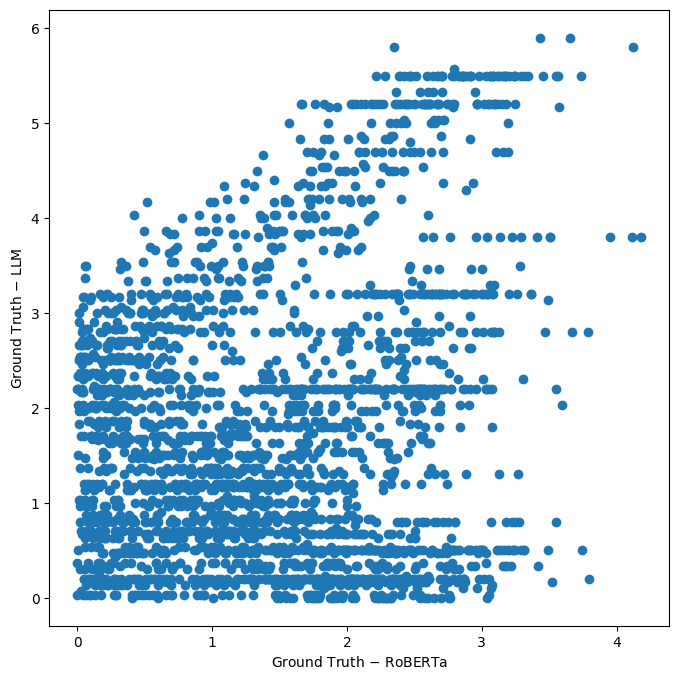

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(residual_model, residual_llm)
plt.xlabel("Ground Truth $-$ RoBERTa")
plt.ylabel("Ground Truth $-$ LLM")
# plt.savefig(os.path.join(logging_dir, "label_noise.png"), bbox_inches='tight')

Text(0.5, 0, 'Ground Truth $-$ LLM')

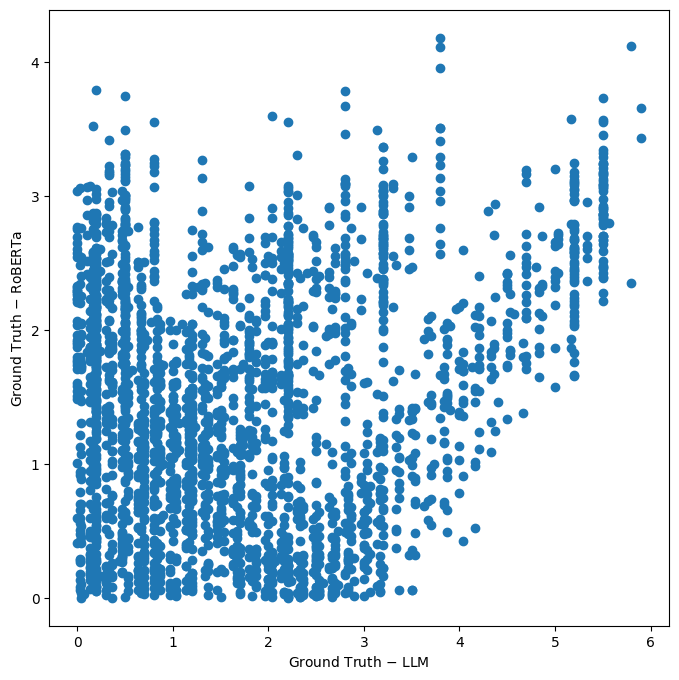

In [29]:
plt.figure(figsize=(8, 8))
plt.scatter(residual_llm, residual_model)
plt.ylabel("Ground Truth $-$ RoBERTa")
plt.xlabel("Ground Truth $-$ LLM")
# plt.savefig(os.path.join(logging_dir, "label_noise.png"), bbox_inches='tight')

In [18]:
np.corrcoef(residual_model, residual_llm)

array([[1.        , 0.19475386],
       [0.19475386, 1.        ]])

In [21]:
threshold = 3
residual_llm_thresholded = residual_llm[residual_model > threshold]
residual_model_thresholded = residual_model[residual_model > threshold]
np.corrcoef(residual_model_thresholded, residual_llm_thresholded)

array([[1.        , 0.09748982],
       [0.09748982, 1.        ]])

In [22]:
threshold = 3
residual_llm_thresholded = residual_llm[residual_llm > threshold]
residual_model_thresholded = residual_model[residual_llm > threshold]
np.corrcoef(residual_model_thresholded, residual_llm_thresholded)

array([[1.       , 0.5284272],
       [0.5284272, 1.       ]])

# MC Dropout

In [2]:
unc = pd.read_csv("../logs/20240903_215551_DetectNoiseLabels_MCD_No_LoRA/mc_dropout_noisy_samples.csv")
unc.head(2)

,sample_index,predictions,uncertainties,ground_truth
0,0,3.741035,0.029715,5.667
1,1,3.762047,0.024778,4.833


In [3]:
unc["sample_index"].duplicated().sum()

0

In [4]:
unc = unc.sort_values('sample_index').set_index('sample_index')

In [5]:
train_df = pd.read_csv('../data/v2_v3_train.tsv', sep='\t')

In [6]:
residual_llm =  np.abs(train_df["crowdsourced_empathy"]-train_df["gpt_empathy"])

Text(0, 0.5, 'Ground Truth $-$ LLM')

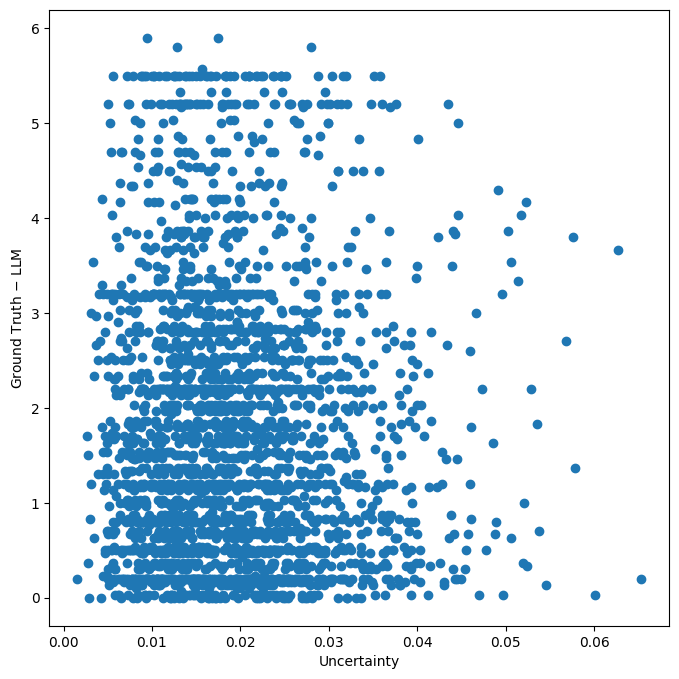

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(unc["uncertainties"], residual_llm)
plt.xlabel("Uncertainty")
plt.ylabel("Ground Truth $-$ LLM")
# plt.savefig(os.path.join(logging_dir, "label_noise.png"), bbox_inches='tight')

In [8]:
np.corrcoef(unc["uncertainties"], residual_llm)

array([[ 1.        , -0.02750192],
       [-0.02750192,  1.        ]])

In [9]:
np.corrcoef(unc["ground_truth"], unc["predictions"])

array([[1.        , 0.01640233],
       [0.01640233, 1.        ]])

## Agentic

In [2]:
hc = np.load("../logs/20240904_193336_DetectNoiseLabels_MCD_No_LoRA/hc_index.npy")
mc = np.load("../logs/20240904_193336_DetectNoiseLabels_MCD_No_LoRA/mc_index.npy")
lc = np.load("../logs/20240904_193336_DetectNoiseLabels_MCD_No_LoRA/lc_index.npy")

train_df = pd.read_csv('../data/v2_v3_train.tsv', sep='\t')

In [4]:
# Calculate the noise (absolute difference between gpt_empathy and crowdsource_empathy)
train_df['noise'] = abs(train_df['gpt_empathy'] - train_df['crowdsourced_empathy'])

# Extract noise values for HC, MC, and LC groups
hc_noise = train_df.loc[hc, 'noise']
mc_noise = train_df.loc[mc, 'noise']
lc_noise = train_df.loc[lc, 'noise']

# Calculate the mean and standard deviation of the noise in each group
hc_mean, hc_std = hc_noise.mean(), hc_noise.std()
mc_mean, mc_std = mc_noise.mean(), mc_noise.std()
lc_mean, lc_std = lc_noise.mean(), lc_noise.std()

# Print out the results
print(f"High Confidence (HC): Mean Noise = {hc_mean:.4f}, Std Dev = {hc_std:.4f}")
print(f"Medium Confidence (MC): Mean Noise = {mc_mean:.4f}, Std Dev = {mc_std:.4f}")
print(f"Low Confidence (LC): Mean Noise = {lc_mean:.4f}, Std Dev = {lc_std:.4f}")

High Confidence (HC): Mean Noise = 1.7170, Std Dev = 1.0385
Medium Confidence (MC): Mean Noise = 1.6691, Std Dev = 1.2890
Low Confidence (LC): Mean Noise = 2.0630, Std Dev = 1.9288


/tmp/ipykernel_2544951/3809270598.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([hc_noise, mc_noise, lc_noise], labels=['HC', 'MC', 'LC'], patch_artist=True)


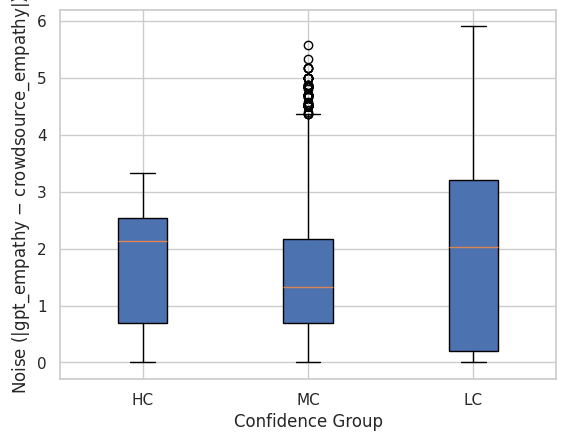

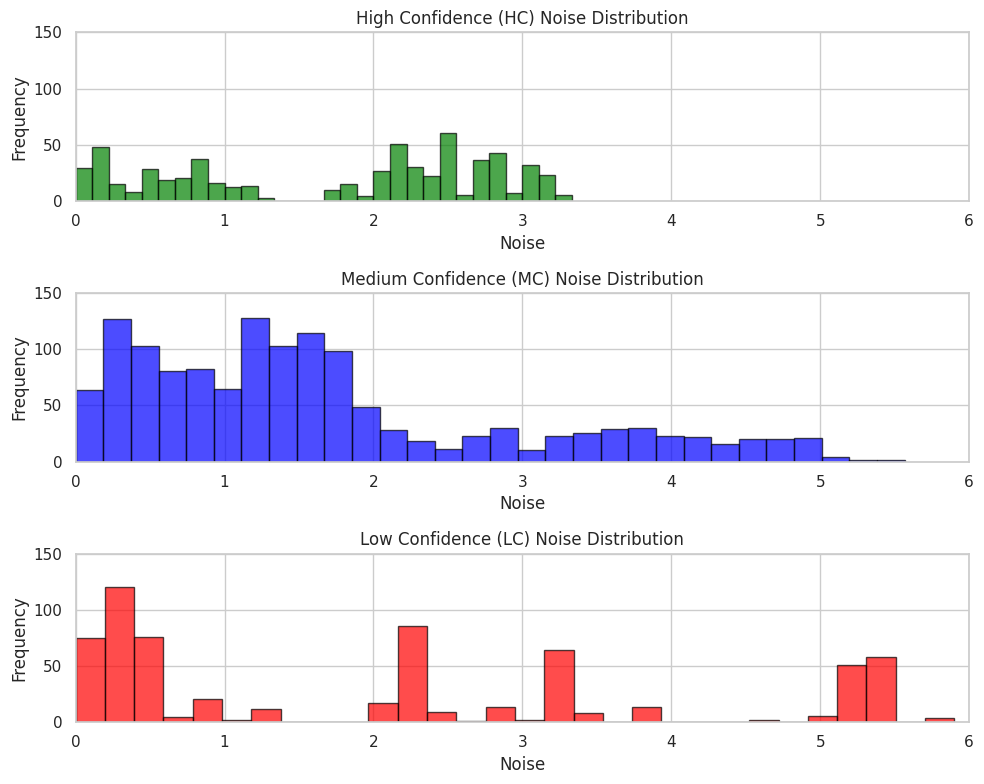

In [13]:
# plt.figure(figsize=(10, 6))

# Boxplot for noise distribution across confidence groups
plt.boxplot([hc_noise, mc_noise, lc_noise], labels=['HC', 'MC', 'LC'], patch_artist=True)
plt.xlabel("Confidence Group")
plt.ylabel("Noise (|gpt_empathy $-$ crowdsource_empathy|)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))

# Histogram for HC group
plt.subplot(3, 1, 1)
plt.hist(hc_noise, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title("High Confidence (HC) Noise Distribution")
plt.xlabel("Noise")
plt.ylabel("Frequency")
plt.xlim(0, 6)
plt.ylim(0, 150)

# Histogram for MC group
plt.subplot(3, 1, 2)
plt.hist(mc_noise, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Medium Confidence (MC) Noise Distribution")
plt.xlabel("Noise")
plt.ylabel("Frequency")
plt.xlim(0, 6)
plt.ylim(0, 150)

# Histogram for LC group
plt.subplot(3, 1, 3)
plt.hist(lc_noise, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.title("Low Confidence (LC) Noise Distribution")
plt.xlabel("Noise")
plt.ylabel("Frequency")
plt.xlim(0, 6)
plt.ylim(0, 150)

plt.tight_layout()
plt.show()